In [1]:
import numpy as np
import pandas as pd
import random
from keras.models import Model, load_model
from keras.layers import Input, Conv1D, BatchNormalization, add, Activation, MaxPooling1D, UpSampling1D
from keras.layers import AveragePooling1D, Concatenate, Flatten
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import loadmat
from os import listdir
import re

Using TensorFlow backend.
/home/luke/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/luke/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/luke/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/luke/.local/lib/python3.6/site-packages/tensorflow/python/framewo

In [2]:
files = listdir('./data')
files

['level_100.mat',
 'incline_selfpace.mat',
 'level_075.mat',
 'level_selfpaced.mat',
 'incline_075.mat',
 'decline_075.mat',
 'level_050.mat',
 'decline_selfpace.mat',
 'level_125.mat']

In [3]:
def getData():
    data = dict()
    files = listdir('./data')
    for file in files:
        path = './data/' + file
        mat = loadmat(path)  # load mat-file
        mdata = mat['EEG']  # variable in mat file
        mdtype = mdata.dtype  # dtypes of structures are "unsized objects"
        # * SciPy reads in structures as structured NumPy arrays of dtype object
        # * The size of the array is the size of the structure array, not the number
        #   elements in any particular field. The shape defaults to 2-dimensional.
        # * For convenience make a dictionary of the data using the names from dtypes
        # * Since the structure has only one element, but is 2-D, index it at [0, 0]
        ndata = {n: mdata[n][0, 0] for n in mdtype.names}
        length = ndata['data'].shape[1]
        data[path] = length
    return data
data = getData()
data

{'./data/level_100.mat': 46500,
 './data/incline_selfpace.mat': 47400,
 './data/level_075.mat': 47100,
 './data/level_selfpaced.mat': 46950,
 './data/incline_075.mat': 46800,
 './data/decline_075.mat': 46800,
 './data/level_050.mat': 47100,
 './data/decline_selfpace.mat': 47100,
 './data/level_125.mat': 46950}

In [110]:
test = np.random.randint(0,96,2)
test

array([29, 80])

In [4]:
def getFrame(fname):
    mat = loadmat(fname)  # load mat-file
    mdata = mat['EEG']  # variable in mat file
    mdtype = mdata.dtype  # dtypes of structures are "unsized objects"
    # * SciPy reads in structures as structured NumPy arrays of dtype object
    # * The size of the array is the size of the structure array, not the number
    #   elements in any particular field. The shape defaults to 2-dimensional.
    # * For convenience make a dictionary of the data using the names from dtypes
    # * Since the structure has only one element, but is 2-D, index it at [0, 0]
    ndata = {n: mdata[n][0, 0] for n in mdtype.names}
    
    #create dataframe dictionary
    cols = dict()
    curr = 0
    for chan in range(ndata['data'].shape[0]):
        string = "chan" + str(curr)
        cols[string] = ndata['data'][curr]
        curr += 1
    df=pd.DataFrame(cols)
    
    #rescale from 0 - 512
    maxes = df.apply(np.max)
    mins = df.apply(np.min)
    for n in range(len(maxes)):
        maxes[n] = maxes[n] - mins[n]
        df[maxes.index[n]] = (df[maxes.index[n]] - mins[n])/maxes[n]*511
    df = df.astype(int)
    return df

df = getFrame('./data/level_100.mat')
maxes = df.apply(np.max)
mins = df.apply(np.min)
print(maxes, mins)

chan0      511
chan1      511
chan2      511
chan3      511
chan4      511
          ... 
chan123    511
chan124    511
chan125    511
chan126    511
chan127    511
Length: 128, dtype: int64 chan0      0
chan1      0
chan2      0
chan3      0
chan4      0
          ..
chan123    0
chan124    0
chan125    0
chan126    0
chan127    0
Length: 128, dtype: int64


In [5]:
def makeArrays(data):
    keyList = list(data.keys())
    arrayChunks = []
    for n in range(len(keyList)):
        #print(keyList[n])
        df = getFrame(keyList[n])
        for chunk in data[keyList[n]]:
            cf = df[chunk[0]:chunk[1]].copy()
            target = np.zeros((9))
            target[n] = 1
            arrayChunks.append([np.array(cf), target])
    random.shuffle(arrayChunks)
    X, Y = zip(*arrayChunks)
    X = np.array(X)
    Y = np.array(Y)
    print(X.shape, Y.shape)
    return (X, Y)

In [9]:
DEF_LR = .01
DEF_LR_DEC = .01
POOLS = [8,6,4,2]
STEPS = 384
NUM_FILTERS = 9
KERNEL_SIZE = 5
DILATION = 2
EPOCHS = 10

class ConvNetwork:
    
    def __init__(self, batches=27, alpha = DEF_LR, alpha_dec = DEF_LR_DEC, pools = POOLS, steps = STEPS,
                filts = NUM_FILTERS, kernel=KERNEL_SIZE, dilation = DILATION):
        self.batchSize = batches
        self.channels = 128
        self.steps = steps
        self.pools = pools
        self.alpha = alpha
        self.filters = filts
        self.kSize = kernel
        self.dRate = dilation
        self.alpha_decay = alpha_dec
        self.m = self.buildModel()
        
    def TrainModel(self, data):
        self.train = data.copy()
        self.test = data.copy()
        self.indices = data.copy()
        random.seed()
        allDat = 0
        val = min(data.values()) // 384 // 5
        
        #create indices for chunks for validation and training splits
        #create dictionary for number of chunks in training set
        for key in data:
            total = data[key] - 750
            num = total // STEPS
            over = total % STEPS
            start = np.random.randint(0,over)
            curr = 750 + start
            chunks = []
            while curr + STEPS < total + 750:
                chunks.append([curr, curr+STEPS])
                curr += STEPS
            random.shuffle(chunks)
            self.train[key] = chunks[val+1:]
            self.test[key] = chunks[0:val]
            entries = len(chunks) - val - 1
            self.indices[key] = list(range(entries))
            allDat += entries
            
        #prepare first batch data
        self.numDat = allDat
        self.currDat = 0
        self.batch = self.indices.copy()
        X_Val, Y_Val = makeArrays(self.test)
        #print(self.batch)
        histories = self.m.fit_generator(self.batchGenerator(), allDat//self.batchSize + 1, EPOCHS,
                                        validation_data = (X_Val, Y_Val))
        return histories
    
    def batchGenerator(self):
        reset = False
        while True:
            currBatch = dict()
            for key in self.batch:
                numChunks = len(self.batch[key])
                #print(key, numChunks)
                indices = []
                if numChunks >= 3:
                    for index in np.random.randint(0,numChunks-2,3):
                        indices.append(self.batch[key].pop(index))
                else:
                    reset = True
                    for index in self.batch[key]:
                        indices.append(index)
                chunks = []
                for index in indices:
                    if index < len(self.train[key]):
                        chunks.append(self.train[key][index].copy())
                currBatch[key] = chunks
            batch_x, batch_y = makeArrays(currBatch)
            if reset:
                print("Resetting")
                for key in self.train:
                    entries = len(self.train[key])
                    self.batch[key] = list(range(entries))
                reset = False
            yield(batch_x,batch_y)
        
    def lossFunction(self, y_true, y_pred):
        masks = self.masks
        masks = 1. - masks
        num = np.count_nonzero(masks[:,:,:,0])
        masks = tf.convert_to_tensor(masks, dtype=tf.float32)
        logits = tf.math.log(y_pred)
        unred_err = tf.math.multiply(logits,y_true)
        masks = tf.math.multiply(masks,y_true)
        res = tf.math.multiply(masks, logits)
        print(self.num_erased)
        return -(tf.reduce_sum(res)/num)
        
    def buildModel(self):
        data = Input(shape=(self.steps, self.channels))
        featureMaps = []
        #Build Encoder
        pconv1 = Conv1D(self.filters, self.kSize, padding='same',
                        activation = 'relu', dilation_rate=self.dRate)(data)
        pbn1 = BatchNormalization()(pconv1)
        pconv2 = Conv1D(self.filters, self.kSize, padding='same',
                        activation = 'relu', dilation_rate=self.dRate)(pbn1)
        pbn2 = BatchNormalization()(pconv2)
        featureMaps.append(pbn2)
        lastIter = MaxPooling1D(self.pools[0])(pbn2)
        for i in range(1,len(self.pools)):
            conv1 = Conv1D(self.filters, self.kSize, padding='same',
                           activation = 'relu', dilation_rate=self.dRate)(lastIter)
            bn1 = BatchNormalization()(conv1)
            conv2 = Conv1D(self.filters, self.kSize, padding='same',
                           activation = 'relu', dilation_rate=self.dRate)(bn1)
            bn2 = BatchNormalization()(conv2)
            featureMaps.append(bn2)
            lastIter = MaxPooling1D(pool_size = self.pools[i])(bn2)
            
        #Intermediate Convolutions:
        post1 = Conv1D(self.filters, self.kSize, padding='same',
                       activation = 'relu', dilation_rate=self.dRate)(lastIter)
        postbn1 = BatchNormalization()(post1)
        post2 = Conv1D(self.filters, self.kSize, padding='same',
                       activation = 'relu', dilation_rate=self.dRate)(postbn1)
        lastIter = BatchNormalization()(post2)
        
        #Build Decoder:
        for i in range(len(self.pools)):
            ups = UpSampling1D(size=self.pools[3-i])(lastIter)
            c1 = Conv1D(self.filters, self.kSize, padding='same',
                        activation = 'relu', dilation_rate=self.dRate)(ups)
            b1 = BatchNormalization()(c1)
            conc = Concatenate()([b1, featureMaps[3-i]])
            c2 = Conv1D(self.filters, self.kSize, padding='same',
                        activation = 'relu', dilation_rate=self.dRate)(conc)
            b2 = BatchNormalization()(c2)
            c3 = Conv1D(self.filters, self.kSize, padding='same',
                        activation = 'relu', dilation_rate=self.dRate)(b2)
            lastIter = BatchNormalization()(c3)
        
        #Classifier:
        segment = AveragePooling1D(pool_size=self.steps, strides=self.steps)(lastIter)
        output = Conv1D(self.filters, 1, activation='softmax', padding='same')(segment)
        output = Flatten()(output)
        model = Model(inputs=data, outputs=output)
        model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['acc'])
        return model

In [10]:
CN = ConvNetwork()
CN.m.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 384, 128)     0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 384, 9)       5769        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 384, 9)       36          conv1d_24[0][0]                  
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 384, 9)       414         batch_normalization_23[0][0]     
____________________________________________________________________________________________

In [11]:
histories = CN.TrainModel(getData())

(216, 384, 128) (216, 9)
Epoch 1/10
(27, 384, 128) (27, 9)
31/32 [============================>.] - ETA: 7s - loss: 1.9034 - acc: 0.3895 (16, 384, 128) (16, 9)
Resetting
32/32 [==============================] - 254s 8s/step - loss: 1.8895 - acc: 0.3962 - val_loss: 2.0006 - val_acc: 0.1111
Epoch 2/10
(27, 384, 128) (27, 9)
31/32 [============================>.] - ETA: 8s - loss: 1.2355 - acc: 0.7826 (16, 384, 128) (16, 9)
Resetting
32/32 [==============================] - 266s 8s/step - loss: 1.2272 - acc: 0.7855 - val_loss: 2.6131 - val_acc: 0.1111
Epoch 3/10
(27, 384, 128) (27, 9)
14/32 [============>.................] - ETA: 2:25 - loss: 0.7894 - acc: 0.9180(27, 384, 128) (27, 9)


31/32 [============================>.] - ETA: 8s - loss: 0.6911 - acc: 0.9558 (16, 384, 128) (16, 9)
Resetting
32/32 [==============================] - 261s 8s/step - loss: 0.6863 - acc: 0.9566 - val_loss: 2.0544 - val_acc: 0.2315
Epoch 4/10
(27, 384, 128) (27, 9)
31/32 [============================>.] - ETA: 8s - loss: 0.4086 - acc: 0.9988 (16, 384, 128) (16, 9)
Resetting
32/32 [==============================] - 267s 8s/step - loss: 0.4074 - acc: 0.9988 - val_loss: 1.3407 - val_acc: 0.5417
Epoch 5/10
(27, 384, 128) (27, 9)
29/32 [==========================>...] - ETA: 23s - loss: 0.2733 - acc: 0.9987(27, 384, 128) (27, 9)


31/32 [============================>.] - ETA: 7s - loss: 0.2703 - acc: 0.9988 (16, 384, 128) (16, 9)
Resetting
32/32 [==============================] - 255s 8s/step - loss: 0.2698 - acc: 0.9988 - val_loss: 0.5997 - val_acc: 0.8981
Epoch 6/10
(27, 384, 128) (27, 9)
31/32 [============================>.] - ETA: 7s - loss: 0.1953 - acc: 1.0000 (16, 384, 128) (16, 9)
Resetting
32/32 [==============================] - 255s 8s/step - loss: 0.1958 - acc: 1.0000 - val_loss: 0.5311 - val_acc: 0.8889
Epoch 7/10
(27, 384, 128) (27, 9)
31/32 [============================>.] - ETA: 7s - loss: 0.1483 - acc: 1.0000 (16, 384, 128) (16, 9)
Resetting
32/32 [==============================] - 255s 8s/step - loss: 0.1485 - acc: 1.0000 - val_loss: 0.4737 - val_acc: 0.8889
Epoch 8/10
(27, 384, 128) (27, 9)
11/32 [=========>....................] - ETA: 2:47 - loss: 0.1243 - acc: 1.0000(27, 384, 128) (27, 9)


31/32 [============================>.] - ETA: 7s - loss: 0.1164 - acc: 1.0000 (16, 384, 128) (16, 9)
Resetting
32/32 [==============================] - 255s 8s/step - loss: 0.1168 - acc: 1.0000 - val_loss: 0.6391 - val_acc: 0.7778
Epoch 9/10
(27, 384, 128) (27, 9)
31/32 [============================>.] - ETA: 7s - loss: 0.0925 - acc: 1.0000 (16, 384, 128) (16, 9)
Resetting
32/32 [==============================] - 254s 8s/step - loss: 0.0929 - acc: 1.0000 - val_loss: 0.7081 - val_acc: 0.8056
Epoch 10/10
(27, 384, 128) (27, 9)
26/32 [=======================>......] - ETA: 47s - loss: 0.0759 - acc: 1.0000(27, 384, 128) (27, 9)


31/32 [============================>.] - ETA: 7s - loss: 0.0747 - acc: 1.0000 (16, 384, 128) (16, 9)
Resetting
32/32 [==============================] - 254s 8s/step - loss: 0.0750 - acc: 1.0000 - val_loss: 0.1562 - val_acc: 0.9954
(27, 384, 128) (27, 9)


In [16]:
histories.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

<IPython.core.display.Javascript object>


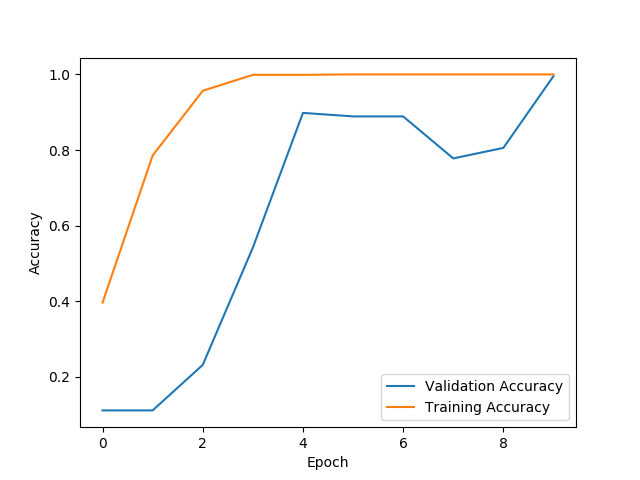

In [18]:
%matplotlib notebook
plt.figure()
plt.plot(list(range(EPOCHS)), histories.history['val_acc'], label = 'Validation Accuracy')
plt.plot(list(range(EPOCHS)), histories.history['acc'], label = 'Training Accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()